That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [49]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [50]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

In [51]:
fname = '/u/ki/swmclau2/des/PearceMCMC/HOD2_wp_ds_rmin_None_HOD.hdf5'

In [52]:
f = h5py.File(fname, 'r')

In [53]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [54]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5'],
      dtype='|S59')

In [55]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5
/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5


In [56]:
chain_pnames = f.attrs['param_names']

In [57]:
n_walkers = f.attrs['nwalkers']

In [58]:
n_burn = 1000
chain = f['chain'][n_burn*n_walkers:, :]

In [59]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [60]:
print chain.shape, chain.shape[0]/n_walkers

(1573750, 12) 6295


In [61]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [62]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.32131552e-02  1.09344254e-01 -6.26118317e-01  9.97357515e-01
  7.04713711e+01  2.62477451e+00  9.64254553e-01  1.42206148e+01
  1.30089351e+01  5.09005676e-02  9.38223566e-01  1.02215587e+00]


In [63]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [64]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [65]:
MAP_dict

{'H0': 70.47137106264658,
 'Neff': 2.6247745050767963,
 'alpha': 0.9382235657457967,
 'conc_gal_bias': 1.022155867039396,
 'logM0': 13.00893506439755,
 'logM1': 14.220614818120271,
 'ns': 0.9973575150567379,
 'ombh2': 0.023213155156741064,
 'omch2': 0.10934425354773289,
 'sigma8': 0.9642545529529809,
 'sigma_logM': 0.05090056763489566,
 'w0': -0.6261183174782126}

In [66]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [67]:
MAP_dict.update(fixed_params)

In [68]:
MAP_dict

{'H0': 70.47137106264658,
 'Neff': 2.6247745050767963,
 'alpha': 0.9382235657457967,
 'conc_gal_bias': 1.022155867039396,
 'logM0': 13.00893506439755,
 'logM1': 14.220614818120271,
 'ns': 0.9973575150567379,
 'ombh2': 0.023213155156741064,
 'omch2': 0.10934425354773289,
 'sigma8': 0.9642545529529809,
 'sigma_logM': 0.05090056763489566,
 'w0': -0.6261183174782126,
 'z': 0.0}

In [69]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [70]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [71]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [72]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [73]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [74]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [75]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [76]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [77]:
true_data = f['data'][()]#.flatten()

In [78]:
true_data = true_data.reshape((2, -1))

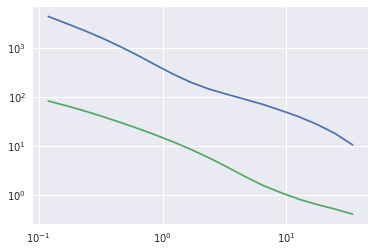

In [79]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [80]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [81]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

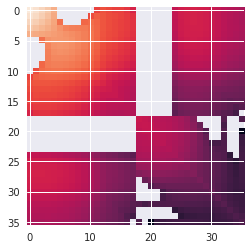

In [82]:
plt.imshow(np.log10(cov) )

In [83]:
(true_data[1]/(10**emus[1].emulate_wrt_r(true_param_dict).squeeze() ) )

array([1.1999577 , 1.09289223, 1.05019147, 1.03621321, 1.03446303,
       1.03563602, 1.0426657 , 1.04878234, 1.05072549, 1.04581793,
       1.03604699, 1.01015823, 0.99909097, 1.01646099, 1.01874476,
       1.04148602, 1.07153396, 1.07579672])

In [84]:
true_data

array([[4.33783634e+03, 3.13381486e+03, 2.25153635e+03, 1.57403764e+03,
        1.06160587e+03, 6.95503740e+02, 4.42890433e+02, 2.85510667e+02,
        1.94121345e+02, 1.42366768e+02, 1.11451261e+02, 8.81371051e+01,
        6.93379513e+01, 5.23965040e+01, 3.89945884e+01, 2.73804260e+01,
        1.79238926e+01, 1.04164244e+01],
       [8.15712995e+01, 6.56554185e+01, 5.15683274e+01, 3.97248519e+01,
        3.01238129e+01, 2.24806957e+01, 1.65201668e+01, 1.18840849e+01,
        8.30485887e+00, 5.60413304e+00, 3.66253659e+00, 2.33831276e+00,
        1.54477100e+00, 1.09979958e+00, 8.11507170e-01, 6.33007941e-01,
        5.10682449e-01, 4.02136346e-01]])

In [85]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

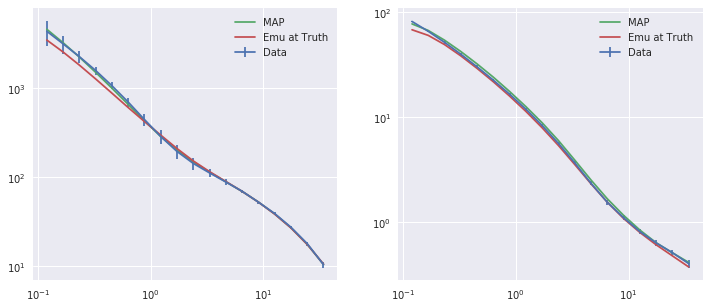

In [86]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

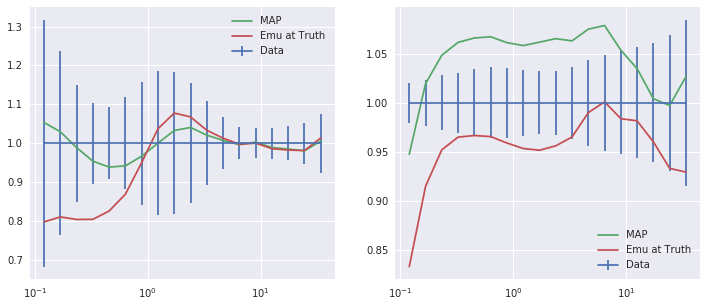

In [87]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [88]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [89]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [90]:
print 'True Red. Chi2'
R = (10**true_pred.flatten()-true_data.flatten())

chi2 =  R.T.dot(inv(cov)).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
10.970749246146069


In [91]:
print 'Map Red. Chi2'
R = (10**MAP_pred.flatten()-true_data.flatten())

chi2 =  R.T.dot(inv(cov)).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
4.359400926059053


In [92]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [93]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

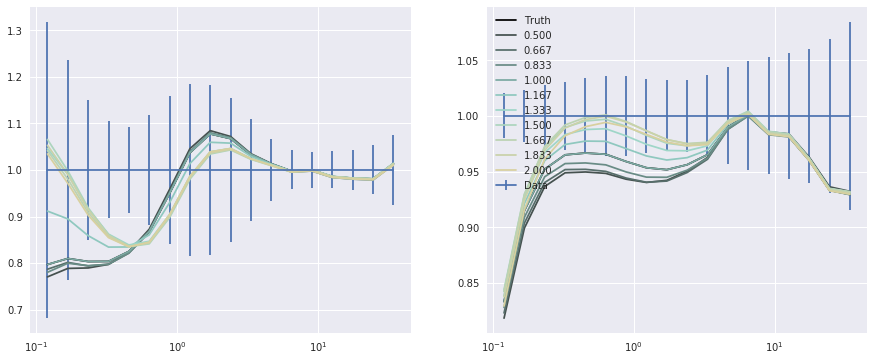

In [94]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'conc_gal_bias'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();